In [4]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re
import os
import pickle
model = SentenceTransformer('all-MiniLM-L6-v2') 

def get_embedding(text_path):
    try:
        with open(text_path, 'r', encoding='utf-8') as f:
            text = f.read().strip()
        return model.encode(text, convert_to_numpy=True)
    except Exception as e:
        print(f"[Embedding Error] {text_path}: {e}")
        return None

def find_latest_versioned_folder(base_name, root_dir):
    """Returns the path to the highest version of a folder like 2301.00123v1, v2, etc."""
    candidates = [f for f in os.listdir(root_dir) if f.startswith(base_name + 'v')]
    versions = []
    for folder in candidates:
        match = re.search(r'v(\d+)$', folder)
        if match:
            versions.append((int(match.group(1)), folder))
    if versions:
        latest_folder = max(versions)[1]
        return os.path.join(root_dir, latest_folder)
    return None  # fallback

def add_embeddings_to_graph(G, root_dir):
    for node in G.nodes:
        folder_path = find_latest_versioned_folder(node, root_dir)
        if folder_path is None:
            print(f"⚠️ No versioned folder found for {node}")
            continue
        abstract_path = os.path.join(folder_path, 'abstract.txt')
        embedding = get_embedding(abstract_path)
        if embedding is not None:
            G.nodes[node]['embedding'] = embedding

def compute_similarity(emb1, emb2):
    return cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0]





In [5]:
graph_path = 'citation_graph_with_embeddings.pkl'
root_dir = 'dataset_papers'  # directory with abstract.txt files
output_path = 'citation_graph_with_embeddings.pkl'
with open(graph_path, 'rb') as f:
    citation_graph = pickle.load(f)


# # Add node embeddings
# add_embeddings_to_graph(citation_graph, root_dir)

# # Save updated graph
# with open(output_path, 'wb') as f:
#     pickle.dump(citation_graph, f)

# print(f"✅ Embeddings added. Saved to {output_path}")

# get_top_k_similar_papers(citation_graph, query_node="2104.09750", root_dir=root_dir, k=5)
# k = 10
# get_top_k_predicted_citations(citation_graph, query_node='2411.01713', root_dir='./dataset_papers/', m=5, k=k)



In [ ]:
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity


def compute_in_neighbor_similarity(u_emb, v, G):
    sims = []
    for z in G.predecessors(v):
        emb_z = G.nodes[z].get('embedding')
        if emb_z is not None:
            sim = cosine_similarity(u_emb.reshape(1, -1), emb_z.reshape(1, -1))[0][0]
            if sim > 0.98:  # Avoid self-similarity
                continue
            sims.append(sim)
    if sims:
        sims.sort(reverse=True)
        if len(sims)>4:
            bruh = sims[:5]
        else:
            bruh = sims
        if len(sims) > 9:
            bruh2 = np.mean(sims[:10])
        else:
            bruh2 = np.mean(sims)*0.9 
            
        return [np.mean(bruh), np.mean(bruh2),np.max(sims),len(sims)]
    else:
        return [0.0, 0.0, 0.0, 0.0]

from sklearn.model_selection import train_test_split

def create_link_prediction_dataset_with_split(G, val_ratio=0.015, num_negative_samples=None, verbose=True):
    pos_samples, neg_samples = [], []
    u_nodes = set()

    # Positive edges
    for u, v in G.edges():
        emb_u, emb_v = G.nodes[u].get('embedding'), G.nodes[v].get('embedding')
        if emb_u is not None and emb_v is not None:
            sim_mean, sim2_mean, sim_max, num = compute_in_neighbor_similarity(emb_u, v, G)
            feature = [float(sim_mean), sim2_mean, float(sim_max), num]
            pos_samples.append((u, feature, 1))
            u_nodes.add(u)

    # Negative edges
    all_nodes = list(G.nodes)
    existing_edges = set(G.edges())
    neg_target = num_negative_samples or len(pos_samples) * 2
    attempts, max_attempts = 0, neg_target * 10

    while len(neg_samples) < neg_target and attempts < max_attempts:
        u, v = random.sample(all_nodes, 2)
        if (u, v) in existing_edges:
            attempts += 1
            continue
        emb_u, emb_v = G.nodes[u].get('embedding'), G.nodes[v].get('embedding')
        if emb_u is not None and emb_v is not None:
            sim_mean, sim2_mean, sim_max, num = compute_in_neighbor_similarity(emb_u, v, G)
            feature = [float(sim_mean), sim2_mean, float(sim_max), num]
            neg_samples.append((u, feature, 0))
            u_nodes.add(u)
        attempts += 1

    print(f"✅ Total: {len(pos_samples)} positive, {len(neg_samples)} negative samples")

    # Step 2: Split u-nodes into train/val
    u_nodes = list(u_nodes)
    train_nodes, val_nodes = train_test_split(u_nodes, test_size=val_ratio, random_state=42)

    # Step 3: Partition samples
    X_train, y_train, X_val, y_val = [], [], [], []
    for u, feat, label in pos_samples + neg_samples:
        if u in train_nodes:
            X_train.append(feat)
            y_train.append(label)
        elif u in val_nodes:
            X_val.append(feat)
            y_val.append(label)

    print(f"📊 Split complete: {len(X_train)} train samples, {len(X_val)} val samples")
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), val_nodes


def train_and_evaluate_link_predictor(G):
    X_train, y_train, X_val, y_val,val_nodes = create_link_prediction_dataset_with_split(G)

    clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    clf.fit(X_train, y_train)

    val_probs = clf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_probs)
    acc = accuracy_score(y_val, (val_probs > 0.5).astype(int))

    print(f"📈 AUC-ROC: {auc:.4f}")
    print(f"🎯 Accuracy: {acc:.4f}")
    print(f"🔍 Number of u-nodes: {len(val_nodes)}")
    return clf, val_nodes


In [4]:
clf, val_nodes = train_and_evaluate_link_predictor(citation_graph)


✅ Total: 30796 positive, 61592 negative samples
📊 Split complete: 90990 train samples, 1398 val samples
📈 AUC-ROC: 0.9393
🎯 Accuracy: 0.8927
🔍 Number of u-nodes: 99


In [5]:
with open("link_predictor_model.pkl", "wb") as f:
    pickle.dump(clf, f)

print("✅ Model saved as 'link_predictor_model.pkl'")


✅ Model saved as 'link_predictor_model.pkl'


In [7]:
with open("link_predictor_model.pkl", "rb") as f:
    clf = pickle.load(f)


In [8]:
from difflib import get_close_matches
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def strip_version(folder_name):
    return re.sub(r'v\d+$', '', folder_name)

def extract_year_from_arxiv_id(folder):
    folder = strip_version(folder)
    if len(folder) < 4 or not folder[:4].isdigit():
        return None, None
    year = int(folder[:2])
    month = int(folder[2:4])
    return year, month

def extract_year_from_bib_entry(text):
    match = re.search(r'year\s*=\s*\{(\d{4})\}', text)
    if match:
        return int(match.group(1))
    return None

def extract_year_from_bbl_entry(entry_text):
    match = re.search(r',\s*(\d{4})\.', entry_text)
    if match:
        return int(match.group(1))
    return None

def build_title_to_paper_map(root_dir, nodes_file_path="nodes.txt"):
    title_to_folder = {}
    folder_to_title = {}

    with open(nodes_file_path, 'w', encoding='utf-8') as node_file:
        for folder in os.listdir(root_dir):
            title_file = os.path.join(root_dir, folder, "title.txt")
            if not os.path.exists(title_file):
                continue
            try:
                with open(title_file, 'r', encoding='utf-8') as f:
                    raw_title = f.read()
                    normalized_title = normalize_text(raw_title)
                    base_folder = strip_version(folder)
                    title_to_folder[normalized_title] = base_folder
                    folder_to_title[base_folder] = normalized_title
                    node_file.write(f"{base_folder}\t{normalized_title}\n")
            except Exception as e:
                print(f"Error reading title for {folder}: {e}", file=sys.stderr)

    return title_to_folder, folder_to_title

def extract_titles_from_bbl(text, cited_titles_with_years):
    entries = re.split(r'\\bibitem', text)
    for entry in entries:
        lines = entry.splitlines()
        title_parts = []
        started_collecting = False

        for line in lines:
            if '\\newblock' in line:
                if not started_collecting:
                    started_collecting = True
                    title_line = line.replace('\\newblock', '').strip()
                    title_parts.append(title_line)
                else:
                    break
            elif started_collecting:
                title_parts.append(line.strip())

        if title_parts:
            full_title = ' '.join(title_parts)
            full_title = normalize_text(full_title)
            cited_year = extract_year_from_bbl_entry(entry)
            if full_title not in cited_titles_with_years and len(full_title) > 10:
                cited_titles_with_years[full_title] = cited_year

def extract_titles_from_bib(text, cited_titles_with_years):
    matches = re.findall(r'@\w+\s*\{[^,]+,([^@]*)\}', text, re.DOTALL)
    for entry in matches:
        title_match = re.search(r'title\s*=\s*\{([^}]*)\}', entry, re.IGNORECASE)
        if title_match:
            title = normalize_text(title_match.group(1))
            year = extract_year_from_bib_entry(entry)
            if title not in cited_titles_with_years and len(title) > 10:
                cited_titles_with_years[title] = year
def extract_actual_titles_from_bib_bbl(folder_path):
    cited_titles = set()
    cited_titles_with_years = {}
    for file in os.listdir(folder_path):
        if file.endswith('.bib') or file.endswith('.bbl'):
            file_path = os.path.join(folder_path, file)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()
            except:
                with open(file_path, 'r', encoding='latin-1') as f:
                    text = f.read()
            if file.endswith('.bib'):
                extract_titles_from_bib(text, cited_titles_with_years)
            else:
                extract_titles_from_bbl(text, cited_titles_with_years)
    for t in cited_titles_with_years.keys():
        cited_titles.add(normalize_text(t))
    return cited_titles

In [9]:
def evaluate_predicted_citations_data(G, clf, query_node, root_dir, k=5):
    query_folder = find_latest_versioned_folder(query_node, root_dir)
    if not query_folder:
        return None

    query_emb = get_embedding(os.path.join(query_folder, "abstract.txt"))
    if query_emb is None:
        return None

    scores = []
    for target in G.nodes:
        if target == query_node:
            continue

        emb_t = G.nodes[target].get("embedding")
        if emb_t is None:
            continue

        sim_mean, sim_mean2, sim_max, num = compute_in_neighbor_similarity(query_emb, target, G)
        feat = [float(sim_mean), sim_mean2, float(sim_max), num]
        prob = clf.predict_proba([feat])[0][1]
        scores.append((prob, target))

    scores.sort(reverse=True)
    predicted_topk = scores[:k]
    predicted = [(G.graph['folder_to_title'].get(cited, cited), prob) for prob, cited in predicted_topk]

    # Extract actual citations
    actual_titles = extract_actual_titles_from_bib_bbl(query_folder)
    graph_titles = set(normalize_text(t) for t in G.graph['folder_to_title'].values())
    actual_in_graph = [title for title in actual_titles if get_close_matches(title, graph_titles, n=1, cutoff=0.9)]

    return {
        "query_node": query_node,
        "actual_titles_in_graph": actual_in_graph,
        "predicted": predicted
    }
def print_evaluation_result(result, k=5):
    print(f"\n📄 Query Paper: {result['query_node']}")
    print("\n📎 Actual Citations (in graph):")
    for title in result["actual_titles_in_graph"]:
        print(f"     - {title}")

    print(f"\n🔮 Top {k} Predicted Citations:")
    match_count = 0
    for title, prob in result["predicted"][:k]:
        norm_title = normalize_text(title)
        fuzzy_match = get_close_matches(norm_title, result["actual_titles_in_graph"], n=1, cutoff=0.9)
        marker = "✅" if fuzzy_match else "❌"
        print(f"  {marker} {title} — Prob: {prob:.4f}")
        if fuzzy_match:
            match_count += 1

    print(f"\n✅ Match Score: {match_count}/{k} predictions matched actual citations (fuzzy).")

In [10]:
from matplotlib import pyplot as plt

def compute_recall_at_k(eval_data, ks=[1, 3, 5, 10]):
    """Compute recall@k for various values of k using evaluation data."""
    recall_at_k = {k: [] for k in ks}
    
    for data in eval_data:
        actual_set = set(data['actual_titles_in_graph'])
        predicted_titles = [normalize_text(title) for title, _ in data['predicted']]

        for k in ks:
            top_k_pred = set(predicted_titles[:k])
            matches = top_k_pred & actual_set
            if actual_set:
                recall = len(matches) / len(actual_set) 
            else:
                continue
            recall_at_k[k].append(recall)

    avg_recall = {k: np.mean(recall_at_k[k]) for k in ks}
    return avg_recall


In [10]:
eval_data = []
import random
for node in random.sample(val_nodes, 50):
    res = evaluate_predicted_citations_data(citation_graph, clf, node, root_dir, k=500)
    if res:
        eval_data.append(res)

# Print 5 random evaluations

# for r in random.sample(eval_data, 5):
#     print_evaluation_result(r, k=20)

In [11]:
recall_scores = compute_recall_at_k(eval_data, ks=[1, 5, 10, 20, 50,100])
print(recall_scores)
eval_data2 = []

for node in random.sample(sorted(citation_graph.nodes), 50):
    res = evaluate_predicted_citations_data(citation_graph, clf, node, root_dir, k=500)
    if res:
        eval_data2.append(res)
recall_scores2 = compute_recall_at_k(eval_data2, ks=[1, 5, 10, 20, 50, 100])
# plot_recall_at_k(recall_scores)
ks = list(recall_scores.keys())
values1 = list(recall_scores.values())
values2 = list(recall_scores2.values())


{1: 0.08089457890594254, 5: 0.2708765944394287, 10: 0.35050936696992846, 20: 0.4217703438124561, 50: 0.5389394084079914, 100: 0.6274689214528787}


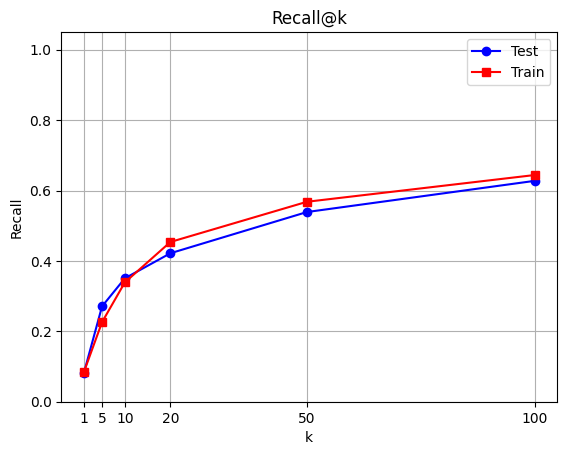

In [12]:
plt.plot(ks,values1,label="Test",color='blue',marker='o')
plt.plot(ks,values2,label='Train', color='red', marker='s')
plt.xlabel('k')
plt.ylabel('Recall')
plt.title("Recall@k")
plt.legend()
plt.grid(True)
plt.xticks(ks)
plt.ylim(0, 1.05)
plt.show()

In [15]:
from collections import defaultdict
def get_top_k_predicted_citations_data(G, query_node, root_dir, m=10, k=5):
    query_folder = find_latest_versioned_folder(query_node, root_dir)
    if not query_folder:
        return None

    query_embedding = get_embedding(os.path.join(query_folder, 'abstract.txt'))
    if query_embedding is None:
        return None

    similarities = []
    for node in G.nodes:
        if node == query_node:
            continue
        emb = G.nodes[node].get('embedding')
        if emb is not None:
            score = compute_similarity(query_embedding, emb)
            similarities.append((score, node))

    similarities.sort(reverse=True)
    top_m = similarities[:m]

    citation_scores = defaultdict(float)
    for sim_score, similar_node in top_m:
        weight = np.exp(sim_score)
        for cited in G.successors(similar_node):
            citation_scores[cited] += weight

    predicted = sorted(citation_scores.items(), key=lambda x: -x[1])[:k]
    predicted_pairs = [(G.graph['folder_to_title'].get(cid, cid), score) for cid, score in predicted]

    # Extract actual citations
    cited_titles_with_years = {}
    for file in os.listdir(query_folder):
        if file.endswith('.bib') or file.endswith('.bbl'):
            file_path = os.path.join(query_folder, file)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
            except:
                with open(file_path, 'r', encoding='latin-1') as f:
                    content = f.read()
            if file.endswith('.bib'):
                extract_titles_from_bib(content, cited_titles_with_years)
            else:
                extract_titles_from_bbl(content, cited_titles_with_years)

    actual_titles = set(cited_titles_with_years.keys())
    graph_titles = set(normalize_text(t) for t in G.graph['folder_to_title'].values())
    actual_in_graph = [title for title in actual_titles if get_close_matches(title, graph_titles, n=1, cutoff=0.9)]

    return {
        "query_node": query_node,
        "actual_titles_in_graph": actual_in_graph,
        "predicted": predicted_pairs
    }

def print_top_k_predicted_citations_result(result, k=5):
    print(f"\n📄 Query Paper: {result['query_node']}")
    print("\n📎 Actual Citations (in graph):")
    for title in result["actual_titles_in_graph"]:
        print(f"     - {title}")

    print(f"\n🔮 Top {k} Predicted Citations:")
    match_count = 0
    for title, score in result["predicted"][:k]:
        norm_title = normalize_text(title)
        fuzzy_match = get_close_matches(norm_title, result["actual_titles_in_graph"], n=1, cutoff=0.9)
        marker = "✅" if fuzzy_match else "❌"
        print(f"  {marker} {title} — Score: {score:.4f}")
        if fuzzy_match:
            match_count += 1

    print(f"\n✅ Match Score: {match_count}/{k} predictions matched actual citations (fuzzy).")

In [14]:
def evaluate_top_k_predicted_citations_on_random_nodes(G, root_dir, num_nodes=50, m=10, k_list=[1, 5, 10, 20, 50, 100]):
    """Evaluate get_top_k_predicted_citations_data on a random sample of nodes."""
    all_nodes = list(G.nodes)
    sampled_nodes = random.sample(all_nodes, num_nodes)
    eval_data = []

    for query_node in sampled_nodes:
        result = get_top_k_predicted_citations_data(G, query_node, root_dir, m=m, k=max(k_list))
        if result:
            eval_data.append(result)

    return eval_data

In [29]:
'''
Since this appraoch is independent of the link prediction model, we can use it to evaluate the performance of the top-k predicted citations for any node. 
'''
eval_data = evaluate_top_k_predicted_citations_on_random_nodes(G=citation_graph, root_dir='./dataset_papers', num_nodes=50, m=30)




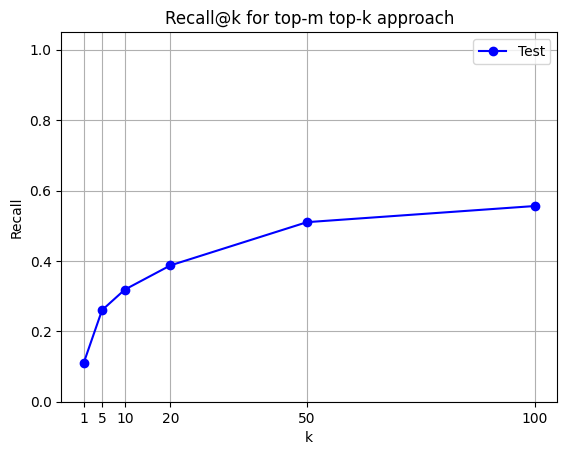


📄 Query Paper: 2006.07793

📎 Actual Citations (in graph):

🔮 Top 10 Predicted Citations:
  ❌ pytorch an imperative style highperformance deep learning library — Score: 10.5440
  ❌ learning transferable visual models from natural language supervision — Score: 10.2973
  ❌ batch normalization accelerating deep network training by reducing internal covariate shift — Score: 7.1072
  ❌ interaction networks for learning about objects relations and physics — Score: 6.8677
  ❌ a simple neural network module for relational reasoning — Score: 5.1371
  ❌ droidslam deep visual slam for monocular stereo and rgbd cameras — Score: 3.4979
  ❌ implicit geometric regularization for learning shapes — Score: 3.4894
  ❌ embed to control a locally linear latent dynamics model for control from raw images — Score: 3.4569
  ❌ draw a recurrent neural network for image generation — Score: 3.4327
  ❌ neural message passing for quantum chemistry — Score: 3.4219

✅ Match Score: 0/10 predictions matched actual citat

In [30]:
recall_scores3 = compute_recall_at_k(eval_data, ks=[1, 5, 10, 20, 50, 100])
ks = list(recall_scores3.keys())
values1 = list(recall_scores3.values())
plt.plot(ks,values1,label="Test",color='blue',marker='o')
plt.xlabel('k')
plt.ylabel('Recall')
plt.title("Recall@k for top-m top-k approach")
plt.legend()
plt.grid(True)
plt.xticks(ks)
plt.ylim(0, 1.05)
plt.show()



import random
for r in random.sample(eval_data, 5):
    print_top_k_predicted_citations_result(r, k=10)

In [41]:
'''
Since this appraoch is independent of the link prediction model, we can use it to evaluate the performance of the top-k predicted citations for any node. 
'''
eval_data = evaluate_top_k_predicted_citations_on_random_nodes(G=citation_graph, root_dir='./dataset_papers', num_nodes=50, m=25)

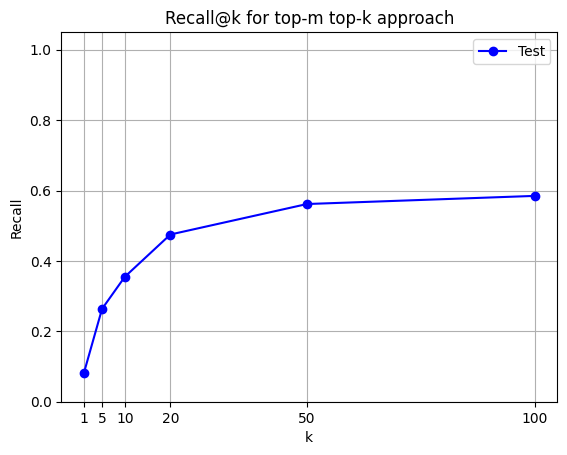


📄 Query Paper: 1906.00232

📎 Actual Citations (in graph):
     - gaussian process conditional density estimation

🔮 Top 10 Predicted Citations:
  ❌ kernel instrumental variable regression — Score: 13.2416
  ❌ dual instrumental variable regression — Score: 5.7222
  ❌ pytorch an imperative style highperformance deep learning library — Score: 5.6995
  ❌ estimating the effects of continuousvalued interventions using generative adversarial networks — Score: 5.4987
  ❌ a class of algorithms for general instrumental variable models — Score: 5.4987
  ❌ the causal neural connection expressiveness learnability and inference — Score: 5.4987
  ❌ orthogonal machine learning power and limitations — Score: 3.7312
  ❌ variational inference with normalizing flows — Score: 3.5282
  ❌ adapting neural networks for the estimation of treatment effects — Score: 3.5168
  ❌ wasserstein adversarial examples via projected sinkhorn iterations — Score: 3.5012

✅ Match Score: 0/10 predictions matched actual citati

In [42]:
recall_scores3 = compute_recall_at_k(eval_data, ks=[1, 5, 10, 20, 50, 100])
ks = list(recall_scores3.keys())
values1 = list(recall_scores3.values())
plt.plot(ks,values1,label="Test",color='blue',marker='o')
plt.xlabel('k')
plt.ylabel('Recall')
plt.title("Recall@k for top-m top-k approach")
plt.legend()
plt.grid(True)
plt.xticks(ks)
plt.ylim(0, 1.05)
plt.show()



import random
for r in random.sample(eval_data, 5):
    print_top_k_predicted_citations_result(r, k=10)

In [39]:


# res = evaluate_predicted_citations_data(citation_graph, clf, '1809.02196', root_dir, k=500)


# print_evaluation_result(res, k=20)

In [16]:
query_node = '2501.00200'
result1 = get_top_k_predicted_citations_data(citation_graph, query_node, root_dir, m=10, k=20)
result2 = get_top_k_predicted_citations_data(citation_graph, query_node, root_dir, m=30, k=20)
res = evaluate_predicted_citations_data(citation_graph, clf, query_node, root_dir, k=500)

print_top_k_predicted_citations_result(result1,k=20)
print_top_k_predicted_citations_result(result2,k=20)
print_evaluation_result(res, k=20)


📄 Query Paper: 2501.00200

📎 Actual Citations (in graph):
     - automatic perturbation analysis for scalable certified robustness and beyond
     - toward deeper understanding of neural networks the power of initialization and a dual view on expressivity
     - large margin deep networks for classification
     - characterlevel convolutional networks for text classification
     - sqlrank a listwise approach to collaborative ranking
     - semidefinite relaxations for certifying robustness to adversarial examples
     - enabling certification of verificationagnostic networks via memoryefficient semidefinite programming
     - synthesizing robust adversarial examples
     - do deep nets really need to be deep
     - decaf a deep convolutional activation feature for generic visual recognition
     - popqorn quantifying robustness of recurrent neural networks
     - pytorch an imperative style highperformance deep learning library
     - evasion and hardening of tree ensemble classifier

In [1]:
def enrich_graph_with_exact_titles(G, root_dir):
    """Adds a 'raw_title' attribute to each node using the original title from title.txt."""
    for node in G.nodes:
        folder_path = find_latest_versioned_folder(node, root_dir)
        if folder_path:
            title_path = os.path.join(folder_path, "title.txt")
            try:
                with open(title_path, "r", encoding="utf-8") as f:
                    raw_title = f.read().strip()
                G.nodes[node]['raw_title'] = raw_title
            except Exception as e:
                G.nodes[node]['raw_title'] = None
                print(f"[Warning] Couldn't read title.txt for {node}: {e}")
        else:
            G.nodes[node]['raw_title'] = None
    return G

In [2]:
def enrich_graph_with_exact_titles(G, root_dir):
    """Adds a 'raw_title' attribute to each node using the original title from title.txt."""
    for node in G.nodes:
        folder_path = find_latest_versioned_folder(node, root_dir)
        if folder_path:
            title_path = os.path.join(folder_path, "title.txt")
            try:
                with open(title_path, "r", encoding="utf-8") as f:
                    raw_title = f.read().strip()
                G.nodes[node]['raw_title'] = raw_title
            except Exception as e:
                G.nodes[node]['raw_title'] = None
        else:
            G.nodes[node]['raw_title'] = None
    return G

In [11]:
with open('citation_graph_with_embeddings.pkl', "rb") as f:
    citation_graph = pickle.load(f)

citation_graph_final = enrich_graph_with_exact_titles(citation_graph, root_dir)

final_path = "citation_graph_final.pkl"
with open(final_path, "wb") as f:
    pickle.dump(citation_graph_final, f)
